In [1]:
!pip install XGBoost
!pip install catboost
!pip install optuna
!pip install LightGBM
!pip install optuna-integration[lightgbm]

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier


Оптимизация гиперпараметров LightGBM,XGBoost и CatBoost с использованием Optuna


Загрузка датасетов:


In [34]:
from sklearn.model_selection import train_test_split
df_m_train = pd.read_csv("train_Mortgage.csv")
df_p_train = pd.read_csv("train_Pension.csv")
df_s_train = pd.read_csv("train_Savings.csv")
target_name_1 = "Mortgage"
target_name_2 = "Pension"
target_name_3 = "Savings"
y_train_m = df_m_train[target_name_1]
y_train_p = df_p_train[target_name_2]
y_train_s = df_s_train[target_name_3]
X_train_m = df_m_train.drop(columns=[target_name_1])
X_train_p = df_p_train.drop(columns=[target_name_2])
X_train_s = df_s_train.drop(columns=[target_name_3])

In [35]:
df_m_valid = pd.read_csv("val_Mortgage.csv")
df_p_valid = pd.read_csv("val_Pension.csv")
df_s_valid = pd.read_csv("val_Savings.csv")
y_test_m = df_m_valid[target_name_1]
y_test_p = df_p_valid[target_name_2]
y_test_s = df_s_valid[target_name_3]
X_test_m = df_m_valid.drop(columns=[target_name_1])
X_test_p = df_p_valid.drop(columns=[target_name_2])
X_test_s = df_s_valid.drop(columns=[target_name_3])

In [36]:
X_train_m, X_valid_m, y_train_m, y_valid_m = train_test_split(X_train_m, y_train_m, test_size = 0.15, stratify=y_train_m)
X_train_p, X_valid_p, y_train_p, y_valid_p = train_test_split(X_train_p, y_train_p, test_size = 0.15, stratify=y_train_p)
X_train_s, X_valid_s, y_train_s, y_valid_s = train_test_split(X_train_s, y_train_s, test_size = 0.15, stratify=y_train_s)

In [168]:
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    roc_auc_score,
    precision_score,
    recall_score,
    roc_curve,
)
import matplotlib.pyplot as plt

def evaluate_models(model_1, model_2, model_3, X_test, y_test,target, pos_label='yes'):
    """
    Вычисляет метрики и строит график AUC для модели CatBoostClassifier.

    Параметры:
        model1:
        model2:
        model3:
        X_test: Тестовые данные (признаки).
        y_test: Истинные значения целевой переменной.

    Возвращает:
        Словарь с метриками: accuracy, f1_score, roc_auc, precision, recall.
    """

    # Предсказание вероятностей и классов
    y_pred_proba_1 = model_1.predict_proba(X_test)[:, 1]  # Вероятности для положительного класса
    y_pred_1 = model_1.predict(X_test)  # Предсказанные классы
    y_pred_proba_2 = model_2.predict_proba(X_test)[:, 1]  # Вероятности для положительного класса
    y_pred_2 = model_2.predict(X_test)  # Предсказанные классы
    y_pred_proba_3 = model_3.predict_proba(X_test)[:, 1]  # Вероятности для положительного класса
    y_pred_3 = model_3.predict(X_test)  # Предсказанные классы

    fpr1, tpr1, _ = roc_curve(y_test, y_pred_proba_1)
    roc_auc_1 = auc(fpr1, tpr1)
    fpr2, tpr2, _ = roc_curve(y_test, y_pred_proba_2)
    roc_auc_2 = auc(fpr2, tpr2)
    fpr3, tpr3, _ = roc_curve(y_test, y_pred_proba_3)
    roc_auc_3 = auc(fpr3, tpr3)
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 7))
    sns.lineplot(x=fpr1, y=tpr1, label=f'LightGBM (AUC = {roc_auc_1:.6f})', color='blue')
    sns.lineplot(x=fpr2, y=tpr2, label=f'CatBoost (AUC = {roc_auc_2:.6f})', color='green')
    sns.lineplot(x=fpr3, y=tpr3, label=f'XGBoost (AUC = {roc_auc_3:.6f})', color='red')

    plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.50)')

    # Настраиваем график
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-AUC for ' + target)
    plt.legend(loc='lower right')
    plt.show()

Рассмотрим дефолтные модели.


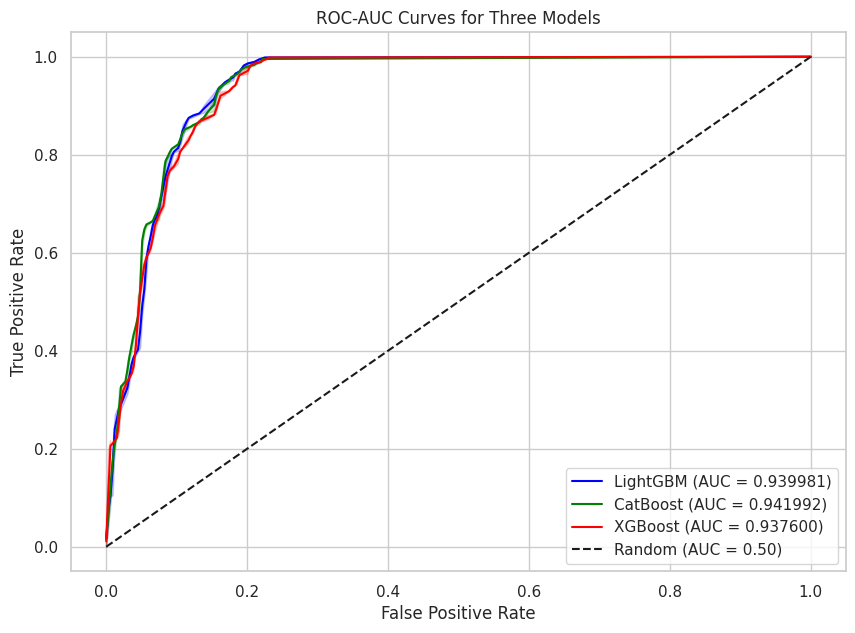

In [165]:
default_model_m_l = LGBMClassifier(verbose=0)
default_model_m_l.fit(X_train_m, y_train_m)
default_model_m = XGBClassifier()
default_model_m.fit(X_train_m,y_train_m)
default_model_m_c = CatBoostClassifier(verbose=0)
default_model_m_c.fit(X_train_m, y_train_m, verbose=False)
evaluate_models(default_model_m_l, default_model_m_c, default_model_m, X_test_m, y_test_m, pos_label=1)

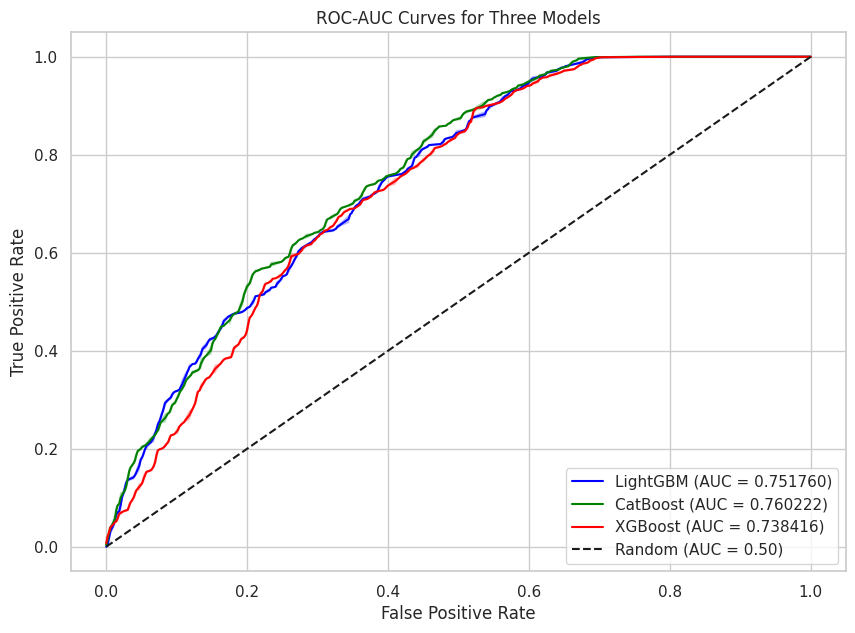

In [62]:
default_model_p_l = LGBMClassifier(verbose=0)
default_model_p_l.fit(X_train_p,y_train_p)
default_model_p_x = XGBClassifier()
default_model_p_x.fit(X_train_p, y_train_p)
default_model_p_c = CatBoostClassifier(verbose=0)
default_model_p_c.fit(X_train_p, y_train_p, verbose=False)
evaluate_models(default_model_p_l, default_model_p_c, default_model_p_x, X_test_p, y_test_p, pos_label=1)

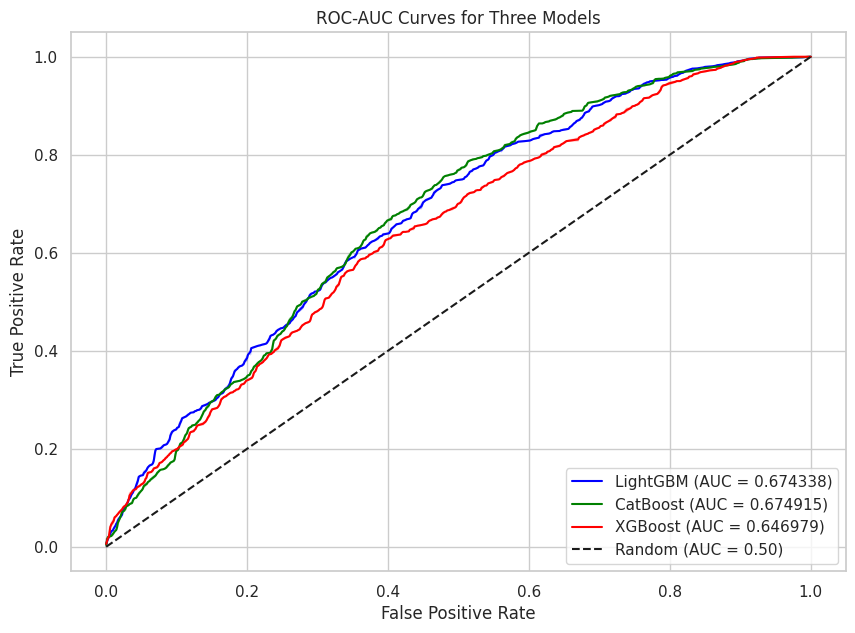

In [63]:
default_model_s_l = LGBMClassifier(verbose=0)
default_model_s_l.fit(X_train_s, y_train_s)
default_model_s_x = XGBClassifier()
default_model_s_x.fit(X_train_s,y_train_s)
default_model_s_c = CatBoostClassifier(verbose=0)
default_model_s_c.fit(X_train_s, y_train_s, verbose=False)
evaluate_models(default_model_s_l, default_model_s_c, default_model_s_x, X_test_s, y_test_s, pos_label=1)

In [116]:
def optimizers(model_lib,X_train, y_train, X_valid, y_valid, n_trials=10, timeout=60*3):
  def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 1500),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1, 10),
        'tree_method': 'hist',
        'random_state': 42,
    }
    model = model_lib(**params)
    model.fit(X_train, y_train)
    y_pred_proba = model.predict_proba(X_valid)[:, 1]
    y_pred = model.predict(X_valid)
    return roc_auc_score(y_valid, y_pred_proba)

  study = optuna.create_study(direction='maximize')
  study.optimize(objective, timeout=timeout)
  return study.best_params

In [117]:
def optimizers_catboost(X_train, y_train, X_valid, y_valid, n_trials=10):
  def objective(trial):
    params = {
        'iterations':trial.suggest_int("iterations", 200, 1400),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10.0, log=True),
        'random_strength': trial.suggest_float('random_strength', 1e-3, 10.0, log=True),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'border_count': trial.suggest_int('border_count', 32, 255),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.2,0.7),
        "max_depth": trial.suggest_int("depth", 1, 8),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        'verbose': False,
        'random_state': 42,
    }

    model = CatBoostClassifier(**params)
    model.fit(X_train, y_train)
    y_pred_proba = model.predict_proba(X_valid)[:, 1]
    y_pred = model.predict(X_valid)
    return roc_auc_score(y_valid, y_pred_proba)

  study = optuna.create_study(direction='maximize')
  study.optimize(objective, timeout=3*60)
  return study.best_params

In [118]:
from optuna.pruners import HyperbandPruner
from optuna.integration import LightGBMPruningCallback

def optimize_lgbm(model_lib, X_train, y_train, X_valid, y_valid, n_trials=10):
    def objective(trial):
        params = {
            'objective': 'binary',
            'metric': 'auc',
            'boosting_type': 'gbdt',
            'n_estimators': trial.suggest_int('n_estimators', 50, 1400),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
            'num_leaves': trial.suggest_int('num_leaves', 20, 300),
            'max_depth': trial.suggest_int('max_depth', 3, 12),
            'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 10.0),
            'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 10.0),
            'random_state': 42,
            'n_jobs': -1,
            'verbosity': -1,
            'early_stopping_rounds': 20,# Отключаем логи LightGBM
        }

        pruning_callback = LightGBMPruningCallback(
            trial,
            metric='auc',
            valid_name='valid_0',
        )

        model = model_lib(**params)
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_valid, y_valid)],  # Обязательно передаем eval_set
            callbacks=[pruning_callback],    # Передаем callback
            #early_stopping_rounds=20,        # Ранняя остановка
            #verbose=False                    # Отключаем вывод
        )

        y_pred_proba = model.predict_proba(X_valid)[:, 1]
        return roc_auc_score(y_valid, y_pred_proba)

    # Настройка HyperbandPruner
    study = optuna.create_study(
        direction='maximize',  # Для roc_auc_score
        pruner=optuna.pruners.HyperbandPruner()
    )
    study.optimize(objective, timeout=60*3)
    return study.best_params

In [94]:
best_m_XGBoost = optimizers(XGBClassifier, X_train_m, y_train_m, X_valid_m, y_valid_m)
best_m_CatBoost = optimizers_catboost(X_train_m, y_train_m, X_valid_m, y_valid_m, n_trials = 30)
best_m_LightGBM = optimize_lgbm(LGBMClassifier, X_train_m, y_train_m, X_valid_m, y_valid_m, n_trials = 500)

[I 2025-04-04 11:03:44,964] A new study created in memory with name: no-name-e8f99a84-1de3-49c8-879d-f19902fb60e6
[I 2025-04-04 11:03:45,780] Trial 0 finished with value: 0.937580142475512 and parameters: {'n_estimators': 484, 'max_depth': 11, 'learning_rate': 0.10951297803332334, 'subsample': 0.6285854283760407, 'colsample_bytree': 0.9329593533086771, 'min_child_weight': 4, 'gamma': 0.5558321778195169, 'reg_alpha': 3.828149199059218, 'reg_lambda': 8.274322677007572, 'scale_pos_weight': 5.996000867312731}. Best is trial 0 with value: 0.937580142475512.
[I 2025-04-04 11:03:46,696] Trial 1 finished with value: 0.9427760463045415 and parameters: {'n_estimators': 387, 'max_depth': 13, 'learning_rate': 0.17299657122949894, 'subsample': 0.9645173239583633, 'colsample_bytree': 0.9301800327656751, 'min_child_weight': 9, 'gamma': 1.1819591939940772, 'reg_alpha': 2.088818704748382, 'reg_lambda': 0.07345827302175256, 'scale_pos_weight': 3.156500328405581}. Best is trial 1 with value: 0.9427760463

KeyboardInterrupt: 

0:	learn: 0.6702905	total: 2.88ms	remaining: 1.61s
250:	learn: 0.1995649	total: 482ms	remaining: 593ms
500:	learn: 0.1888268	total: 1.04s	remaining: 123ms
559:	learn: 0.1861145	total: 1.23s	remaining: 0us


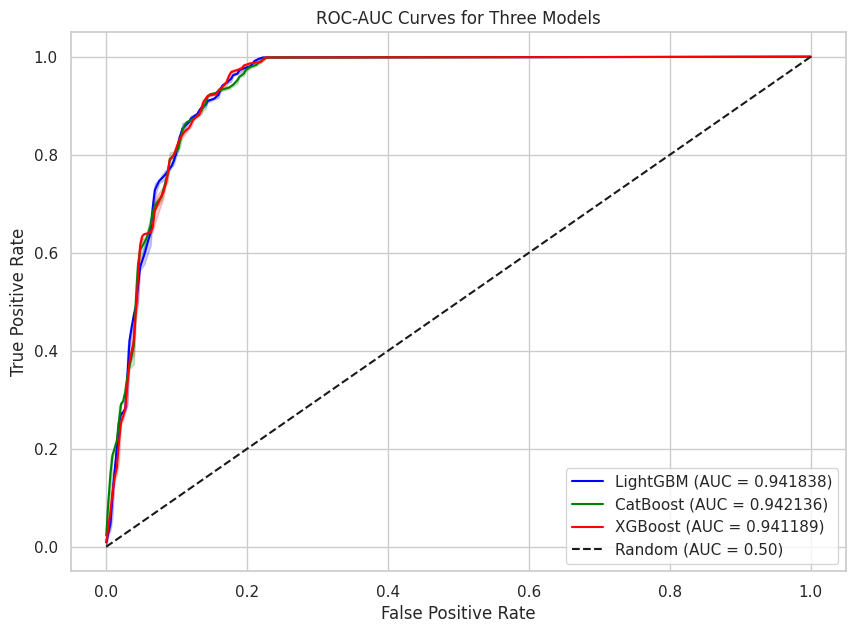

In [102]:
best_model_m_xg = XGBClassifier(**best_m_XGBoost)
best_model_m_xg.fit(X_train_m, y_train_m)
best_model_m_с = CatBoostClassifier(**best_m_CatBoost, verbose=250)
best_model_m_с.fit(X_train_m,y_train_m)
best_model_m_l = LGBMClassifier(**best_m_LightGBM, verbose=-1)
best_model_m_l.fit(X_train_m,y_train_m)
evaluate_models(best_model_m_l, best_model_m_с, best_model_m_xg, X_test_m, y_test_m, pos_label=1)

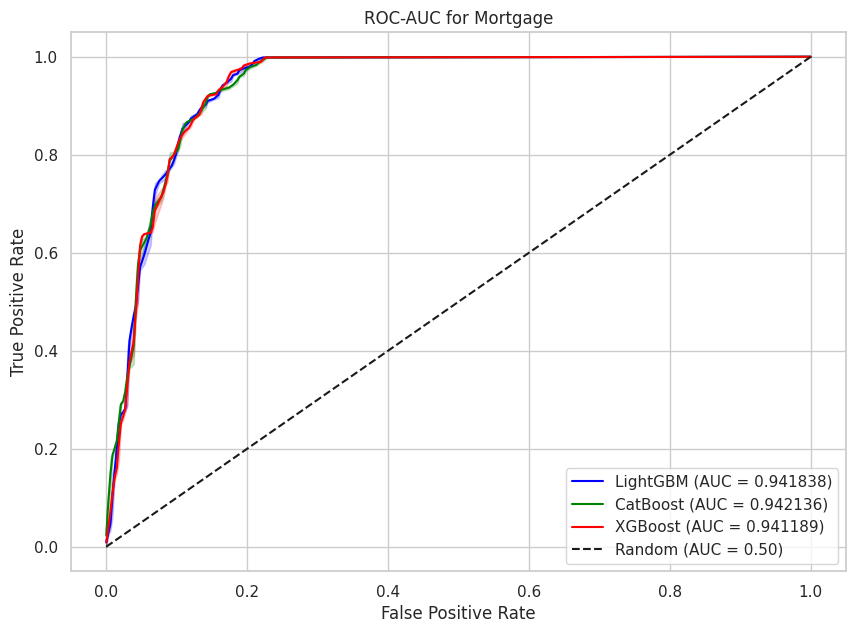

In [169]:
evaluate_models(best_model_m_l, best_model_m_с, best_model_m_xg, X_test_m, y_test_m,"Mortgage", pos_label=1)

In [110]:
best_p_XGBoost = optimizers(XGBClassifier, X_train_p, y_train_p, X_valid_p, y_valid_p)
best_p_CatBoost = optimizers_catboost(X_train_p, y_train_p, X_valid_p, y_valid_p, n_trials = 30)
best_p_LightGBM = optimize_lgbm(LGBMClassifier, X_train_p, y_train_p, X_valid_p, y_valid_p, n_trials = 500)

[I 2025-04-04 11:53:53,081] A new study created in memory with name: no-name-c3f24c0f-0436-4947-8b25-ab220f6fcfd4
[I 2025-04-04 11:53:53,718] Trial 0 finished with value: 0.7285827342874102 and parameters: {'n_estimators': 826, 'max_depth': 3, 'learning_rate': 0.25288398773266196, 'subsample': 0.5979025789523353, 'colsample_bytree': 0.5876360167750461, 'min_child_weight': 1, 'gamma': 1.1767753365868705, 'reg_alpha': 7.104755616903821, 'reg_lambda': 3.92863626550091, 'scale_pos_weight': 3.636245913037257}. Best is trial 0 with value: 0.7285827342874102.
[I 2025-04-04 11:53:55,165] Trial 1 finished with value: 0.7217371232605685 and parameters: {'n_estimators': 1139, 'max_depth': 13, 'learning_rate': 0.13976200848698586, 'subsample': 0.5322821826607438, 'colsample_bytree': 0.8670333385107412, 'min_child_weight': 6, 'gamma': 1.1203346688959503, 'reg_alpha': 6.564762983133302, 'reg_lambda': 5.705060733704003, 'scale_pos_weight': 6.887538211582784}. Best is trial 0 with value: 0.72858273428

0:	learn: 0.6893895	total: 2.97ms	remaining: 592ms
199:	learn: 0.4637299	total: 275ms	remaining: 0us


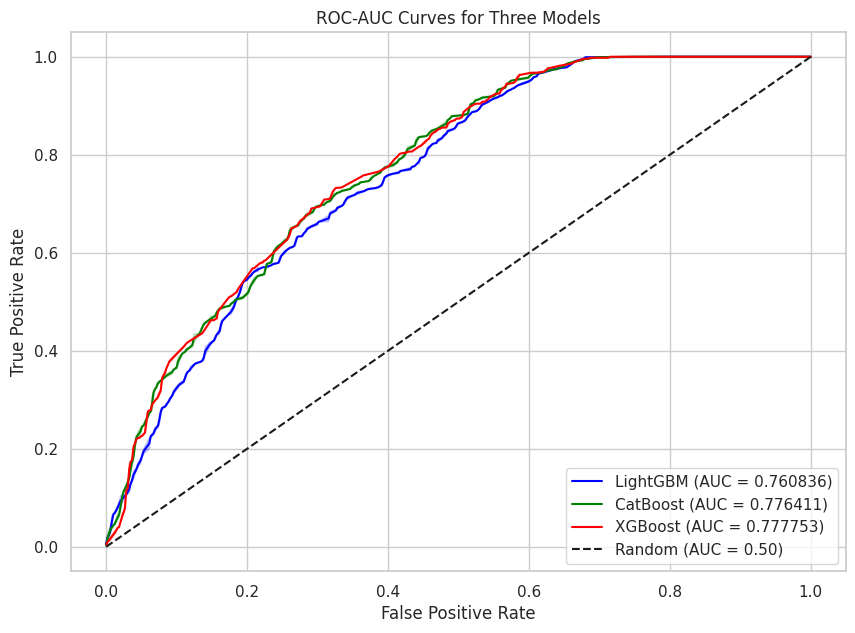

In [111]:
best_model_p_xg = XGBClassifier(**best_p_XGBoost)
best_model_p_xg.fit(X_train_p, y_train_p)
best_model_p_с = CatBoostClassifier(**best_p_CatBoost, verbose=250)
best_model_p_с.fit(X_train_p,y_train_p)
best_model_p_l = LGBMClassifier(**best_p_LightGBM, verbose=-1)
best_model_p_l.fit(X_train_p,y_train_p)
evaluate_models(best_model_p_l, best_model_p_с, best_model_p_xg, X_test_p, y_test_p, pos_label=1)

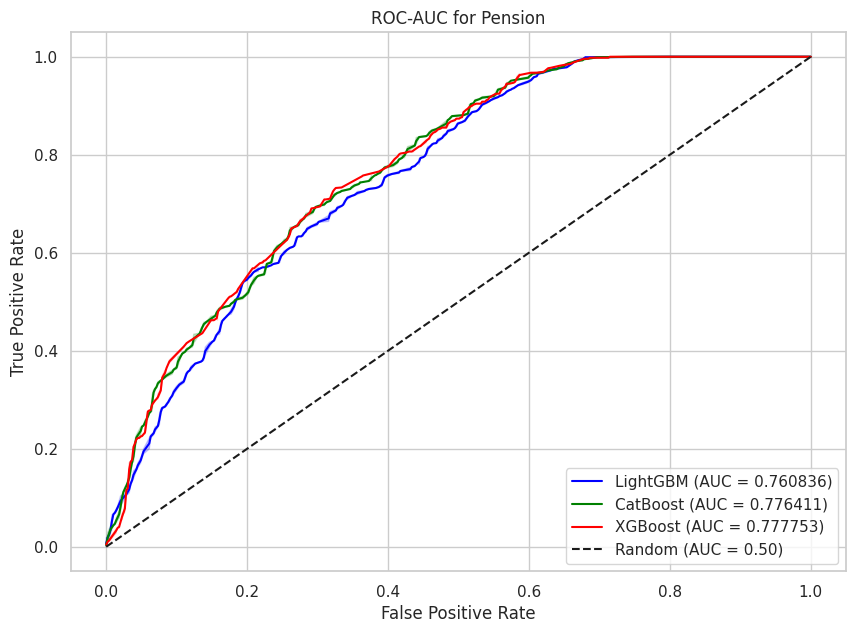

In [170]:
evaluate_models(best_model_p_l, best_model_p_с, best_model_p_xg, X_test_p, y_test_p,"Pension", pos_label=1)

In [119]:
best_s_XGBoost = optimizers(XGBClassifier, X_train_s, y_train_s, X_valid_s, y_valid_s)
best_s_CatBoost = optimizers_catboost(X_train_s, y_train_s, X_valid_s, y_valid_s, n_trials = 30)
best_s_LightGBM = optimize_lgbm(LGBMClassifier, X_train_s, y_train_s, X_valid_s, y_valid_s, n_trials = 500)

[I 2025-04-04 12:15:45,012] A new study created in memory with name: no-name-ffe549a4-4a75-444d-8611-c7a3e4894a5c
[I 2025-04-04 12:15:45,235] Trial 0 finished with value: 0.6554185036933906 and parameters: {'n_estimators': 216, 'max_depth': 12, 'learning_rate': 0.1975636264923912, 'subsample': 0.6457166064829194, 'colsample_bytree': 0.5391068393951715, 'min_child_weight': 4, 'gamma': 4.5417014911394284, 'reg_alpha': 2.5271963481474566, 'reg_lambda': 3.3035677703966106, 'scale_pos_weight': 7.129269311593959}. Best is trial 0 with value: 0.6554185036933906.
[I 2025-04-04 12:15:45,860] Trial 1 finished with value: 0.6598176992690568 and parameters: {'n_estimators': 813, 'max_depth': 6, 'learning_rate': 0.11123101002236159, 'subsample': 0.5771141334264197, 'colsample_bytree': 0.914746338640425, 'min_child_weight': 5, 'gamma': 4.132231002747694, 'reg_alpha': 2.5594362356909848, 'reg_lambda': 2.386973154344738, 'scale_pos_weight': 4.114423498406114}. Best is trial 1 with value: 0.65981769926

In [154]:
best_s_LightGBM = optimize_lgbm(LGBMClassifier, X_train_s, y_train_s, X_valid_s, y_valid_s, n_trials = 500)

[I 2025-04-04 13:16:50,232] A new study created in memory with name: no-name-c073f0b7-170c-4879-84ef-f054d327223c
[I 2025-04-04 13:16:50,299] Trial 0 finished with value: 0.6747665042348301 and parameters: {'n_estimators': 958, 'learning_rate': 0.19400428172615097, 'num_leaves': 299, 'max_depth': 9, 'min_child_samples': 90, 'subsample': 0.5662078164646022, 'colsample_bytree': 0.6076048180034708, 'reg_alpha': 2.5325666812940573, 'reg_lambda': 9.197386567195965}. Best is trial 0 with value: 0.6747665042348301.
[I 2025-04-04 13:16:50,356] Trial 1 finished with value: 0.6788611401167963 and parameters: {'n_estimators': 553, 'learning_rate': 0.017915065344751725, 'num_leaves': 38, 'max_depth': 12, 'min_child_samples': 20, 'subsample': 0.8265133277394765, 'colsample_bytree': 0.5844693003809786, 'reg_alpha': 1.71749047400935, 'reg_lambda': 8.59601521094677}. Best is trial 1 with value: 0.6788611401167963.
[I 2025-04-04 13:16:50,460] Trial 2 finished with value: 0.6807755153343389 and paramete

0:	learn: 0.6849069	total: 2.71ms	remaining: 554ms
204:	learn: 0.5616896	total: 521ms	remaining: 0us


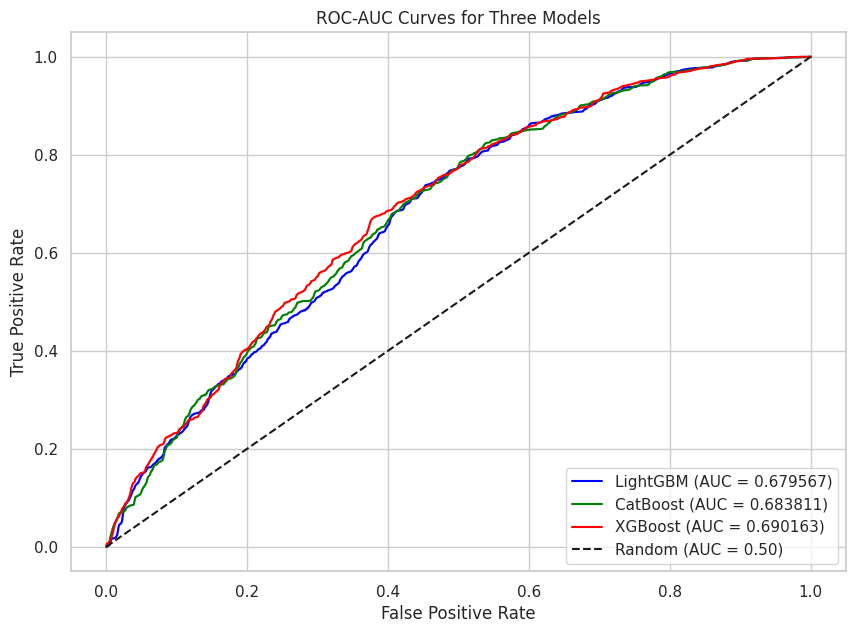

In [155]:
best_model_s_xg = XGBClassifier(**best_s_XGBoost)
best_model_s_xg.fit(X_train_s, y_train_s)
best_model_s_с = CatBoostClassifier(**best_s_CatBoost, verbose=250)
best_model_s_с.fit(X_train_s, y_train_s)
best_model_s_l = LGBMClassifier(**best_s_LightGBM, verbose=-1)
best_model_s_l.fit(X_train_s,y_train_s)
evaluate_models(best_model_s_l, best_model_s_с, best_model_s_xg, X_test_s, y_test_s, pos_label=1)

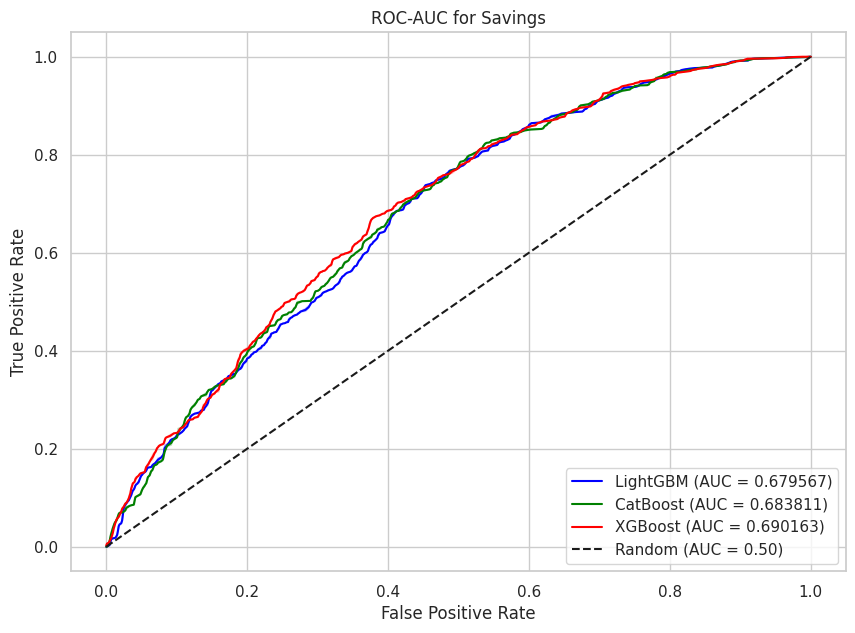

In [172]:
evaluate_models(best_model_s_l, best_model_s_с, best_model_s_xg, X_test_s, y_test_s,"Savings", pos_label=1)

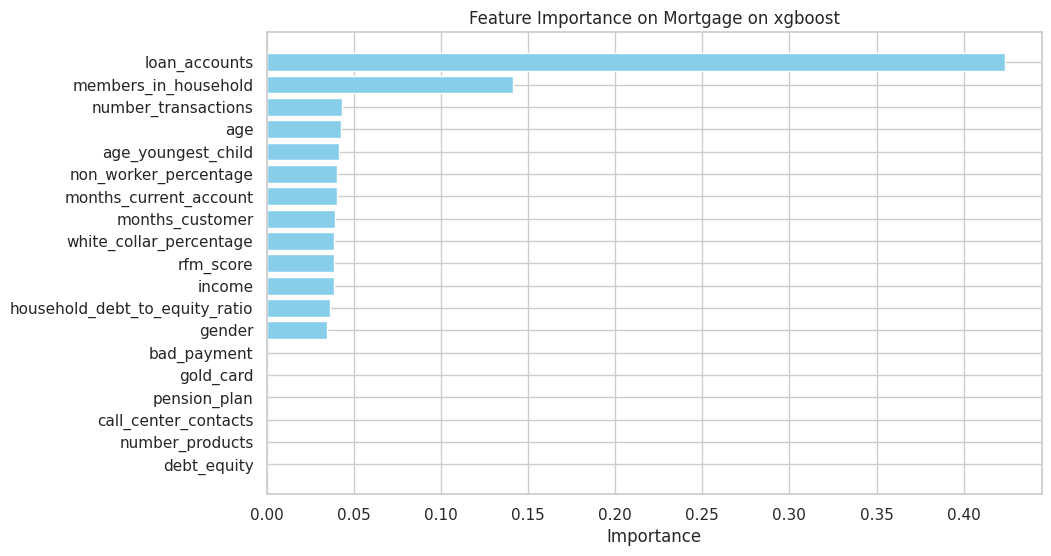

In [156]:
importances_xg = best_model_m_xg.feature_importances_
fi_df_xg = pd.DataFrame({"Feature": X_test_m.columns, "Importance": importances_xg})
fi_df_xg = fi_df_xg.sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10,6))
plt.barh(fi_df_xg["Feature"], fi_df_xg["Importance"], color="skyblue")
plt.gca().invert_yaxis()
plt.xlabel("Importance")
plt.title("Feature Importance on Mortgage on xgboost")
plt.show()

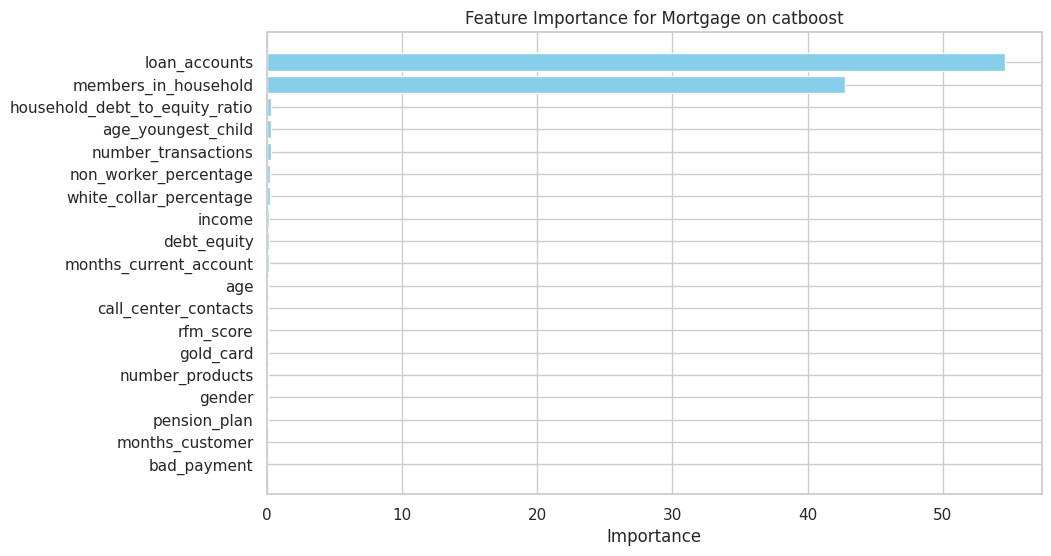

In [157]:
importance_c = best_model_m_с.get_feature_importance()
fi_df_c = pd.DataFrame({"Feature": X_test_m.columns, "Importance": importance_c})
fi_df_c = fi_df_c.sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10,6))
plt.barh(fi_df_c["Feature"], fi_df_c["Importance"], color="skyblue")
plt.gca().invert_yaxis()
plt.xlabel("Importance")
plt.title("Feature Importance for Mortgage on catboost")
plt.show()

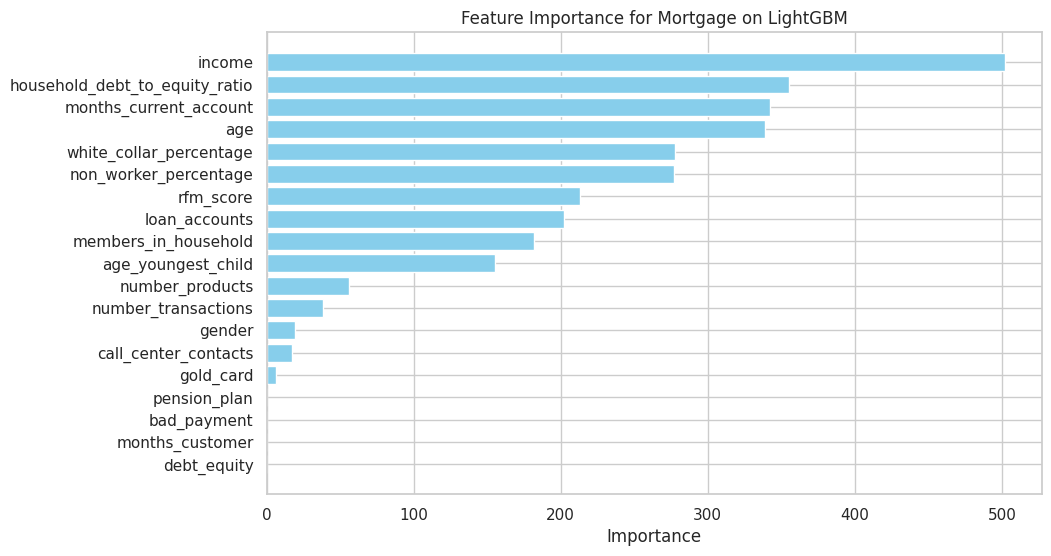

In [158]:
importance_l = best_model_m_l.feature_importances_
fi_df_l = pd.DataFrame({"Feature": X_test_m.columns, "Importance": importance_l})
fi_df_l = fi_df_l.sort_values(by="Importance", ascending=False)


plt.figure(figsize=(10,6))
plt.barh(fi_df_l["Feature"], fi_df_l["Importance"], color="skyblue")
plt.gca().invert_yaxis()
plt.xlabel("Importance")
plt.title("Feature Importance for Mortgage on LightGBM")
plt.show()

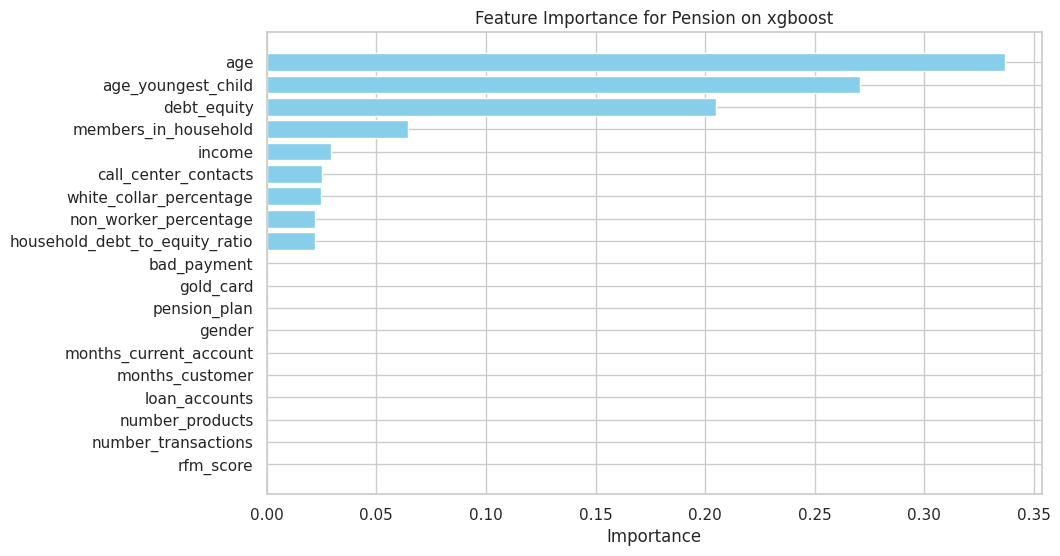

In [159]:
importances_xg = best_model_p_xg.feature_importances_
fi_df_xg = pd.DataFrame({"Feature": X_test_m.columns, "Importance": importances_xg})
fi_df_xg = fi_df_xg.sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10,6))
plt.barh(fi_df_xg["Feature"], fi_df_xg["Importance"], color="skyblue")
plt.gca().invert_yaxis()
plt.xlabel("Importance")
plt.title("Feature Importance for Pension on xgboost")
plt.show()

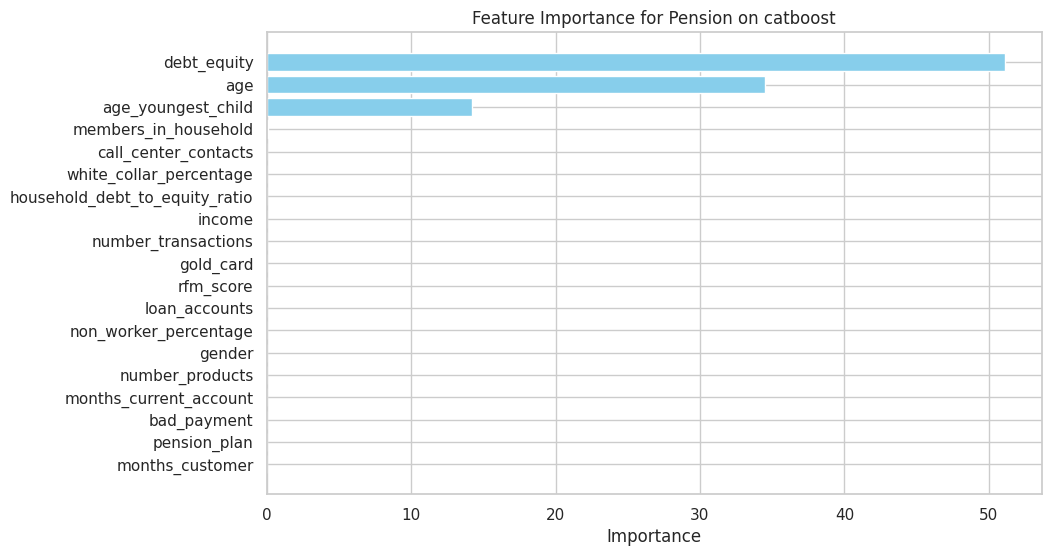

In [160]:
importance_c = best_model_p_с.get_feature_importance()
fi_df_c = pd.DataFrame({"Feature": X_test_m.columns, "Importance": importance_c})
fi_df_c = fi_df_c.sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10,6))
plt.barh(fi_df_c["Feature"], fi_df_c["Importance"], color="skyblue")
plt.gca().invert_yaxis()
plt.xlabel("Importance")
plt.title("Feature Importance for Pension on catboost")
plt.show()

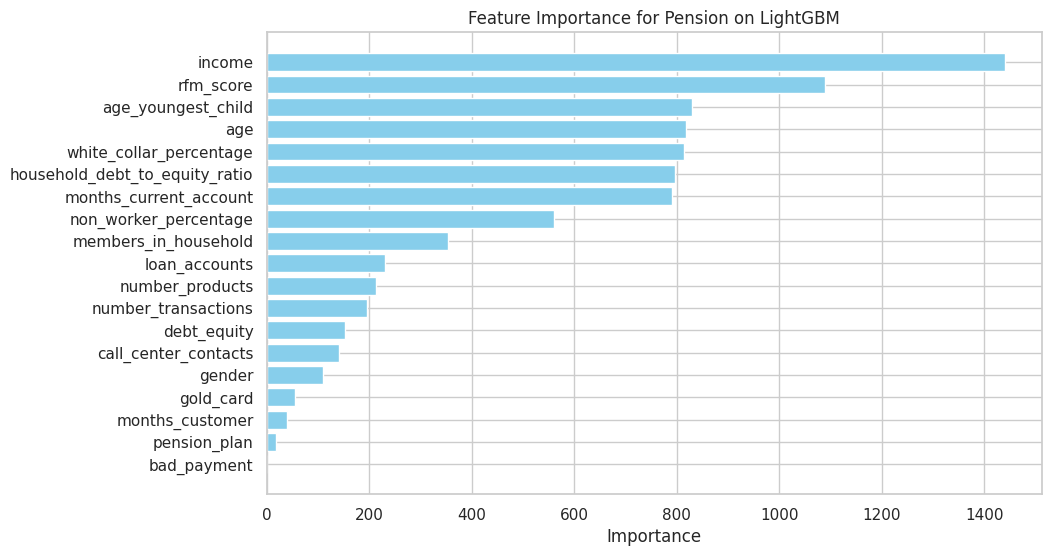

In [161]:
importance_l = best_model_p_l.feature_importances_
fi_df_l = pd.DataFrame({"Feature": X_test_m.columns, "Importance": importance_l})
fi_df_l = fi_df_l.sort_values(by="Importance", ascending=False)


plt.figure(figsize=(10,6))
plt.barh(fi_df_l["Feature"], fi_df_l["Importance"], color="skyblue")
plt.gca().invert_yaxis()
plt.xlabel("Importance")
plt.title("Feature Importance for Pension on LightGBM")
plt.show()

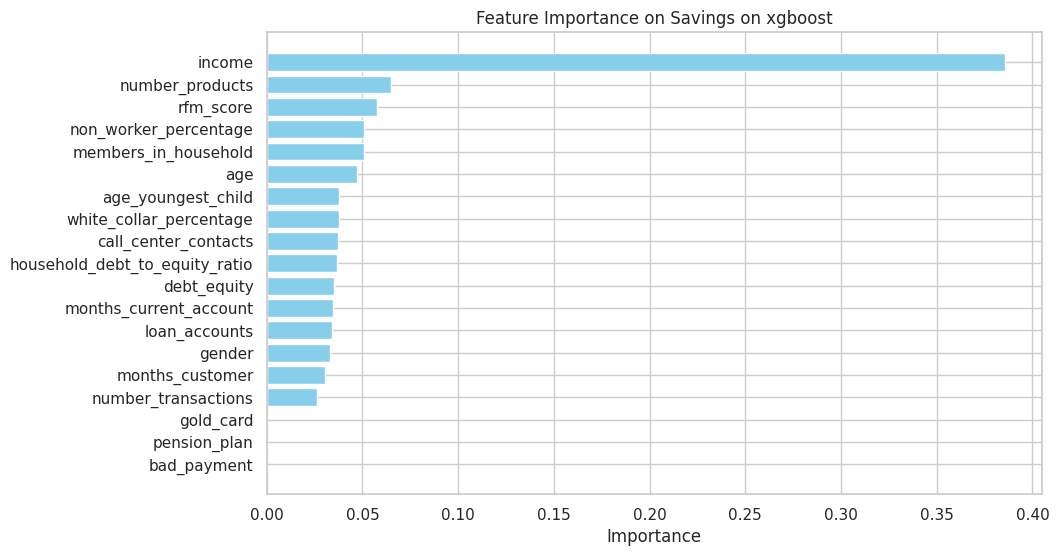

In [162]:
importances_xg = best_model_s_xg.feature_importances_
fi_df_xg = pd.DataFrame({"Feature": X_test_m.columns, "Importance": importances_xg})
fi_df_xg = fi_df_xg.sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10,6))
plt.barh(fi_df_xg["Feature"], fi_df_xg["Importance"], color="skyblue")
plt.gca().invert_yaxis()
plt.xlabel("Importance")
plt.title("Feature Importance on Savings on xgboost")
plt.show()

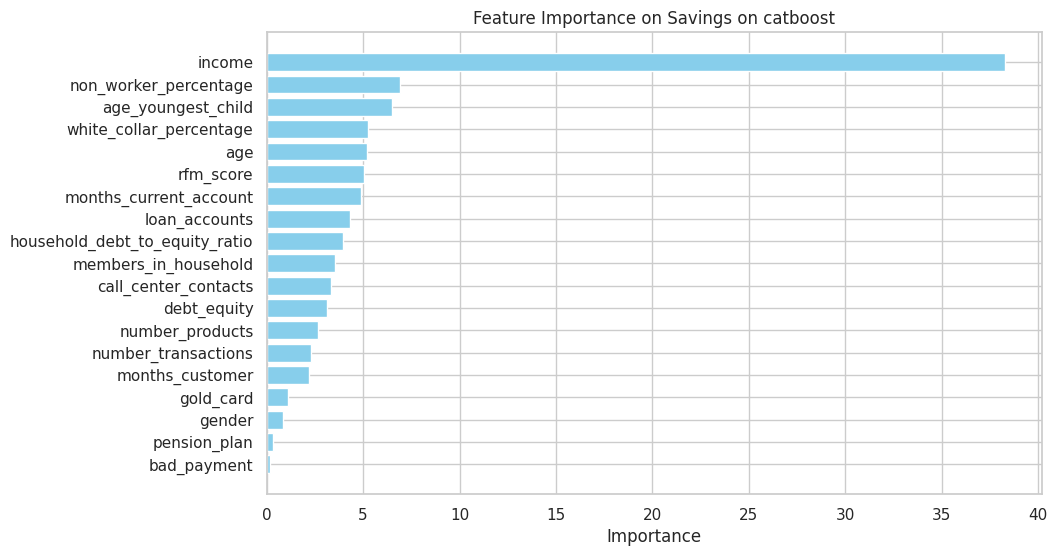

In [163]:
importance_c = best_model_s_с.get_feature_importance()
fi_df_c = pd.DataFrame({"Feature": X_test_m.columns, "Importance": importance_c})
fi_df_c = fi_df_c.sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10,6))
plt.barh(fi_df_c["Feature"], fi_df_c["Importance"], color="skyblue")
plt.gca().invert_yaxis()
plt.xlabel("Importance")
plt.title("Feature Importance on Savings on catboost")
plt.show()

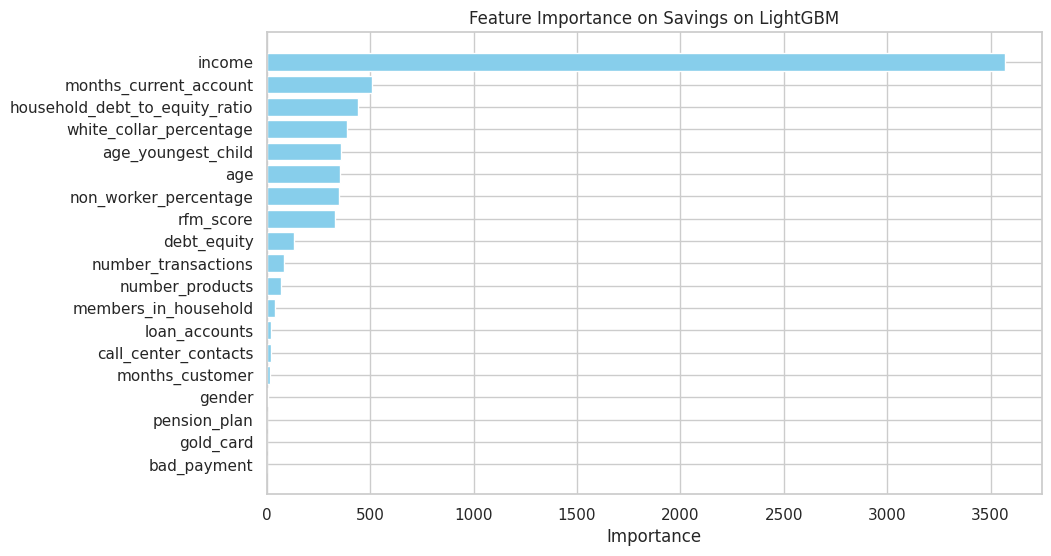

In [164]:
importance_l = best_model_s_l.feature_importances_
fi_df_l = pd.DataFrame({"Feature": X_test_m.columns, "Importance": importance_l})
fi_df_l = fi_df_l.sort_values(by="Importance", ascending=False)


plt.figure(figsize=(10,6))
plt.barh(fi_df_l["Feature"], fi_df_l["Importance"], color="skyblue")
plt.gca().invert_yaxis()
plt.xlabel("Importance")
plt.title("Feature Importance on Savings on LightGBM")
plt.show()

In [178]:
from sklearn.preprocessing import StandardScaler
targets = {
    "Mortgage": (df_m_train, "Mortgage"),
    "Pension": (df_p_train, "Pension"),
    "Savings": (df_s_train, "Savings")
}

# Разделение данных для каждого таргета
datasets = {}
for name, (df, target) in targets.items():
    y = df[target]
    X = df.drop(columns=[target])

    # Разделение на train/val
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    # Нормализация числовых признаков
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)

    datasets[name] = {
        "X_train": torch.FloatTensor(X_train),
        "X_val": torch.FloatTensor(X_val),
        "y_train": torch.FloatTensor(y_train.values).view(-1, 1),
        "y_val": torch.FloatTensor(y_val.values).view(-1, 1)
    }

In [179]:
import torch.nn as nn
import torch
import torch.nn.functional as F

class FiNet(nn.Module):
    def __init__(self, input_dim, hidden_dim=64):
        super().__init__()
        # Слой для обучения взаимодействий
        self.interaction = nn.Linear(input_dim * input_dim, hidden_dim)

        # Полносвязные слои
        self.fc1 = nn.Linear(input_dim + hidden_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        # x: [batch_size, input_dim]
        batch_size = x.shape[0]

        # Вычисляем все попарные взаимодействия
        interactions = torch.bmm(x.unsqueeze(2), x.unsqueeze(1))  # [batch, dim, dim]
        interactions = interactions.view(batch_size, -1)  # [batch, dim*dim]

        # Обработка взаимодействий
        interaction_features = F.relu(self.interaction(interactions))

        # Объединяем исходные признаки и взаимодействия
        combined = torch.cat([x, interaction_features], dim=1)

        # Предсказание
        out = F.relu(self.fc1(combined))
        out = torch.sigmoid(self.fc2(out))
        return out

In [180]:
def train_model(X_train, y_train, X_val, y_val, input_dim, epochs=100):
    model = FiNet(input_dim)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.BCELoss()

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

        # Валидация
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val)
            val_loss = criterion(val_outputs, y_val)

        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}")

    return model

# Обучаем модели
models = {}
for name, data in datasets.items():
    input_dim = data["X_train"].shape[1]
    print(f"Training model for {name}...")
    models[name] = train_model(
        data["X_train"], data["y_train"],
        data["X_val"], data["y_val"],
        input_dim
    )


Training model for Mortgage...
Epoch 0, Train Loss: 0.7881, Val Loss: 0.7465
Epoch 10, Train Loss: 0.5584, Val Loss: 0.5575
Epoch 20, Train Loss: 0.4527, Val Loss: 0.4817
Epoch 30, Train Loss: 0.4081, Val Loss: 0.4480
Epoch 40, Train Loss: 0.3626, Val Loss: 0.3913
Epoch 50, Train Loss: 0.3205, Val Loss: 0.3494
Epoch 60, Train Loss: 0.2813, Val Loss: 0.3164
Epoch 70, Train Loss: 0.2508, Val Loss: 0.2938
Epoch 80, Train Loss: 0.2286, Val Loss: 0.2907
Epoch 90, Train Loss: 0.2103, Val Loss: 0.2972
Training model for Pension...
Epoch 0, Train Loss: 0.7356, Val Loss: 0.7144
Epoch 10, Train Loss: 0.5765, Val Loss: 0.5699
Epoch 20, Train Loss: 0.5235, Val Loss: 0.5285
Epoch 30, Train Loss: 0.4875, Val Loss: 0.4995
Epoch 40, Train Loss: 0.4621, Val Loss: 0.4828
Epoch 50, Train Loss: 0.4420, Val Loss: 0.4719
Epoch 60, Train Loss: 0.4249, Val Loss: 0.4647
Epoch 70, Train Loss: 0.4093, Val Loss: 0.4623
Epoch 80, Train Loss: 0.3944, Val Loss: 0.4666
Epoch 90, Train Loss: 0.3793, Val Loss: 0.4767
T

In [181]:
for name, model in models.items():
    print(f"\nInteractions for {name}:")
    weights = model.interaction.weight.data  # [hidden_dim, input_dim^2]

    # Пример: топ-5 самых сильных взаимодействий
    top_interactions = torch.topk(weights.abs().mean(dim=0), k=5)
    for idx, score in zip(top_interactions.indices, top_interactions.values):
        feat1 = idx // input_dim
        feat2 = idx % input_dim
        print(f"Interaction between features {feat1} and {feat2}: Score = {score:.4f}")


Interactions for Mortgage:
Interaction between features 4 and 13: Score = 0.0695
Interaction between features 13 and 4: Score = 0.0677
Interaction between features 3 and 13: Score = 0.0644
Interaction between features 6 and 13: Score = 0.0624
Interaction between features 13 and 12: Score = 0.0620

Interactions for Pension:
Interaction between features 9 and 5: Score = 0.0564
Interaction between features 5 and 9: Score = 0.0557
Interaction between features 1 and 3: Score = 0.0547
Interaction between features 16 and 8: Score = 0.0543
Interaction between features 5 and 3: Score = 0.0534

Interactions for Savings:
Interaction between features 16 and 13: Score = 0.0653
Interaction between features 13 and 3: Score = 0.0631
Interaction between features 3 and 13: Score = 0.0596
Interaction between features 14 and 16: Score = 0.0595
Interaction between features 13 and 16: Score = 0.0595
